In [60]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import imghdr
import matplotlib.pyplot as plt
import pathlib

In [61]:
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
# print(data_dir)
# data_dir = pathlib.Path(data_dir)
# data_dir

In [62]:
data_dir = pathlib.Path("plant")
data_dir

# Commented out because this is wrong

WindowsPath('plant')

### Remove unreadable file

In [63]:
# Image extensions
image_exts=  ["jpeg", "jpg", "bmp", "png"]

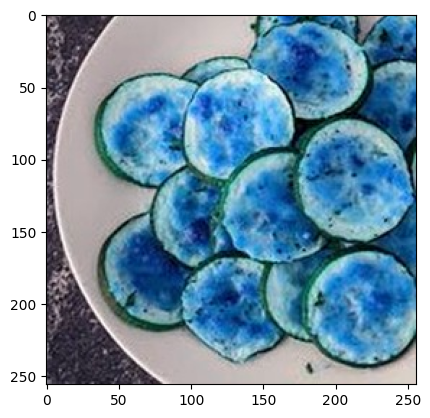

In [64]:
# Going through all the images and removing images that are not right extensions
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        # The full image path
        
        try:
            img = cv2.imread(image_path)
            plt.imshow(img)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print("Removing image : Wrong extension")
                os.remove(image_path)
        except Exception as e:
            print(f"Issue with image {image_path}")
            print(e)

### Resize the pictures

In [65]:
# Go through all the pictures and resize and save the image
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        # Image path
        
        if os.path.isfile(image_path):
            im = PIL.Image.open(image_path)
            f, e = os.path.splitext(image_path)
            imResize = im.resize((256,256), PIL.Image.ANTIALIAS)
            if imResize.mode != 'RGB':
                print(f"Converting {image_path} into RGB")
                imResize = imResize.convert('RGB')
            imResize.save(f + '.jpeg', 'JPEG', quality=90)


C:\Users\abeme\AppData\Local\Temp\ipykernel_23328\3354532628.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  imResize = im.resize((256,256), PIL.Image.ANTIALIAS)


In [66]:
# Clean up the data

In [67]:
batch_size = 32
img_height = 256
img_width = 256

In [68]:
# 
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed = 1,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed = 1,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3531 files belonging to 10 classes.
Using 2825 files for training.
Found 3531 files belonging to 10 classes.
Using 706 files for validation.


In [69]:
class_names = train_ds.class_names
print(class_names)

['bell pepper', 'carrots', 'cauliflower', 'cucumber', 'lettuce', 'onions', 'potato', 'pumpkin', 'tomato', 'zucchini']


In [70]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [71]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [72]:
normalized_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))


In [73]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same',activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [74]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [75]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 32)       

In [76]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
89/89 [==============================] - 46s 490ms/step - loss: 1.7269 - accuracy: 0.3342 - val_loss: 1.4456 - val_accuracy: 0.4731
Epoch 2/10
89/89 [==============================] - 44s 493ms/step - loss: 1.3657 - accuracy: 0.4828 - val_loss: 1.2809 - val_accuracy: 0.5184
Epoch 3/10
89/89 [==============================] - 43s 484ms/step - loss: 1.1759 - accuracy: 0.5696 - val_loss: 1.2853 - val_accuracy: 0.5312
Epoch 4/10
89/89 [==============================] - 42s 475ms/step - loss: 0.9172 - accuracy: 0.6708 - val_loss: 1.2901 - val_accuracy: 0.5567
Epoch 5/10
89/89 [==============================] - 43s 480ms/step - loss: 0.6066 - accuracy: 0.7809 - val_loss: 1.6137 - val_accuracy: 0.4972
Epoch 6/10
89/89 [==============================] - 42s 478ms/step - loss: 0.3514 - accuracy: 0.8747 - val_loss: 1.7704 - val_accuracy: 0.5042
Epoch 7/10
89/89 [==============================] - 42s 477ms/step - loss: 0.2201 - accuracy: 0.9310 - val_loss: 2.5653 - val_accuracy: 0.4858

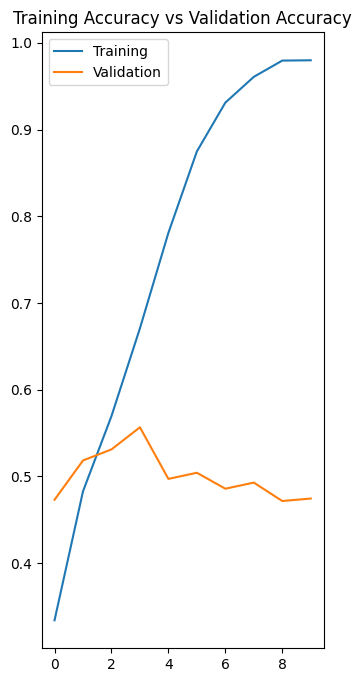

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(10)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend()
plt.title("Training Accuracy vs Validation Accuracy")
plt.show()
